**COMPARATIVE STUDY BETWEEN AN UNSUPERVISED AUTOENCODER AND A SUPERVISED RESNET-50 CLASSIFIER FOR DETECTION OF BRAIN TUMOURS**

In [ ]:
# Mounting Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install opencv-python

In [ ]:
!pip install tensorflow

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import shutil
from collections import Counter
from PIL import Image

import random
import cv2
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import mean_squared_error
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score, precision_score, recall_score
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Dense
from skimage.metrics import structural_similarity as ssim
from tensorflow.keras.preprocessing.image import load_img, img_to_array


from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
# unzip the brain_tumor.zip file
!unzip -q '/content/drive/MyDrive/Brain_Tumor_MRI.zip' -d '/content/brain_tumor'

Dataset Overview

In [ ]:
# dataset directories
data_dir = "/content/brain_tumor/Brain_Tumor_Detection"
tumor_dir = os.path.join(data_dir, "yes")
notumor_dir = os.path.join(data_dir, "no")

In [ ]:
# Count images in each class
tumor_images = os.listdir(tumor_dir)
notumor_images = os.listdir(notumor_dir)

print("Number of tumor images:", len(tumor_images))
print("Number of no tumor images:", len(notumor_images))

Number of tumor images: 1500
Number of no tumor images: 1500


Image Size and Resolution

In [ ]:
# Collect image sizes
all_sizes = []

# Function to get sizes
def get_image_sizes(image_list, directory):
    for img_name in image_list:
        try:
            img_path = os.path.join(directory, img_name)
            with Image.open(img_path) as img:
                all_sizes.append(img.size)  # (width, height)
        except Exception as e:
            print(f"Error reading {img_name}: {e}")

# Check image sizes in both classes
get_image_sizes(tumor_images, tumor_dir)
get_image_sizes(notumor_images, notumor_dir)

# Count frequency of each size
size_counts = Counter(all_sizes)

print("\nImage size distribution:")
for size, count in size_counts.items():
    print(f"Size {size}: {count} images")


Image size distribution:
Size (260, 331): 11 images
Size (240, 300): 23 images
Size (526, 555): 19 images
Size (232, 309): 19 images
Size (294, 355): 15 images
Size (630, 630): 127 images
Size (292, 349): 16 images
Size (256, 256): 17 images
Size (314, 340): 25 images
Size (281, 352): 13 images
Size (216, 234): 13 images
Size (1059, 1200): 13 images
Size (201, 251): 71 images
Size (315, 350): 13 images
Size (300, 325): 9 images
Size (254, 325): 8 images
Size (230, 219): 17 images
Size (291, 340): 18 images
Size (300, 347): 16 images
Size (300, 349): 14 images
Size (200, 249): 1 images
Size (283, 357): 18 images
Size (258, 279): 9 images
Size (273, 342): 18 images
Size (400, 369): 13 images
Size (283, 334): 9 images
Size (300, 353): 18 images
Size (283, 338): 11 images
Size (273, 318): 15 images
Size (297, 348): 11 images
Size (264, 336): 21 images
Size (223, 303): 21 images
Size (279, 354): 15 images
Size (628, 630): 14 images
Size (197, 229): 1 images
Size (293, 337): 17 images
Size 

Checking the File Format

In [ ]:
# Function to get file extensions
def get_file_extensions(image_list):
    extensions = [os.path.splitext(filename)[1].lower() for filename in image_list]
    return extensions

# Get file lists
tumor_files = os.listdir(tumor_dir)
notumor_files = os.listdir(notumor_dir)

# Collect extensions
tumor_exts = get_file_extensions(tumor_files)
notumor_exts = get_file_extensions(notumor_files)

# Count and display
all_exts = tumor_exts + notumor_exts
ext_counts = Counter(all_exts)

print("\nImage file format distribution:")
for ext, count in ext_counts.items():
    print(f"{ext}: {count} images")


Image file format distribution:
.jpg: 3000 images


Class Distribution Visualization

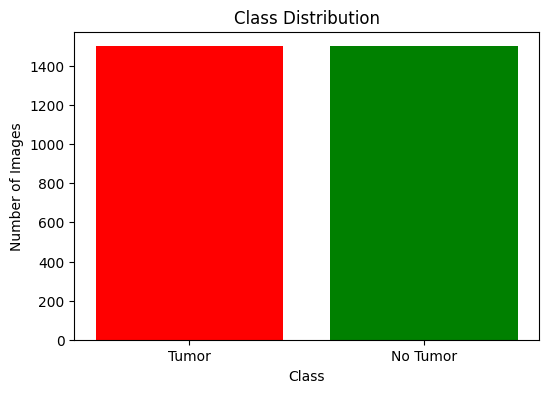

In [ ]:
labels = ['Tumor', 'No Tumor']
counts = [len(tumor_images), len(notumor_images)]

plt.figure(figsize=(6,4))
plt.bar(labels, counts, color=['red', 'green'])
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.show()

 Display Sample Images

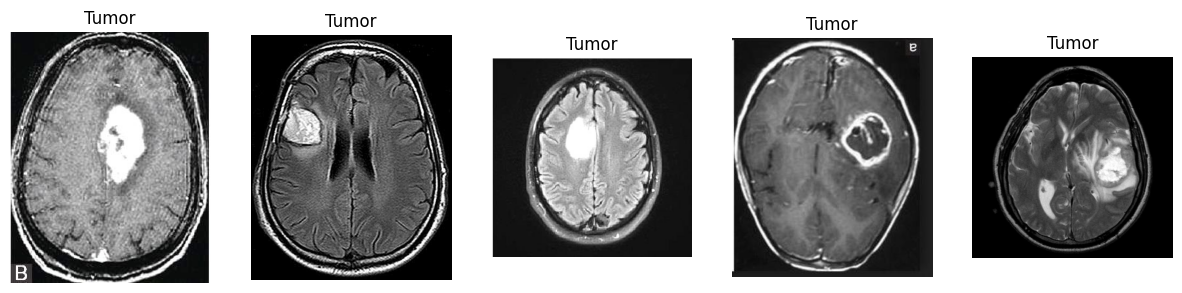

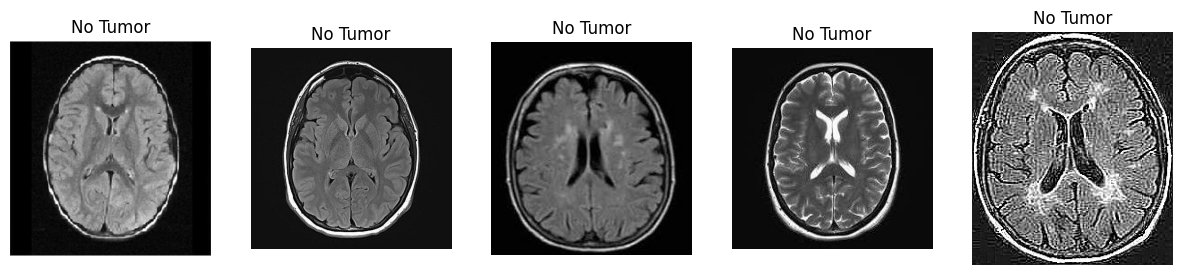

In [ ]:
def show_sample_images(folder, title, n=5):
    images = os.listdir(folder)
    samples = random.sample(images, n)
    plt.figure(figsize=(15, 5))
    for i, image in enumerate(samples):
        img_path = os.path.join(folder, image)
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.subplot(1, n, i+1)
        plt.imshow(img)
        plt.title(f"{title}")
        plt.axis('off')
    plt.show()

show_sample_images(tumor_dir, "Tumor", 5)
show_sample_images(notumor_dir, "No Tumor", 5)

Create new directories for train/test split

In [ ]:
brain_tumor_dir = "/content/brain_tumor"
train_dir = os.path.join(brain_tumor_dir, "Training")
test_dir = os.path.join(brain_tumor_dir, "Testing")
os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)
for cls in ["tumor", "notumor"]:
    os.makedirs(os.path.join(train_dir, cls), exist_ok=True)
    os.makedirs(os.path.join(test_dir, cls), exist_ok=True)

Split and move images

In [ ]:
for label, src_dir in zip(["tumor", "notumor"], [tumor_dir, notumor_dir]):
    all_files = os.listdir(src_dir)
    train_files, test_files = train_test_split(all_files, test_size=0.2, random_state=42)
    for f in train_files:
        shutil.copy(os.path.join(src_dir, f), os.path.join(train_dir, label, f))
    for f in test_files:
        shutil.copy(os.path.join(src_dir, f), os.path.join(test_dir, label, f))


In [ ]:
# Count images in train and test directories
def count_images(directory):
    return sum([len(files) for r, d, files in os.walk(directory)])

print(f"Number of images in train directory: {count_images(train_dir)}")
print(f"Number of images in test directory: {count_images(test_dir)}")


Number of images in train directory: 2400
Number of images in test directory: 600


Data generators

In [ ]:
img_size = (128, 128)
batch_size = 32

datagen = ImageDataGenerator(rescale=1./255)

train_dir_notumor = os.path.join(train_dir, 'notumor')
train_generator_notumor = datagen.flow_from_directory(
    directory=os.path.dirname(train_dir_notumor),
    target_size=img_size,
    batch_size=batch_size,
    classes=['notumor'],
    class_mode='input',
    shuffle=True
)

test_data = test_dir
test_generator = datagen.flow_from_directory(
    test_data,
    target_size=img_size,
    batch_size=batch_size,
    # classes=['notumor', 'tumor'],
    class_mode='input',
    shuffle=False
)

Found 1200 images belonging to 1 classes.
Found 600 images belonging to 2 classes.


# Autoencoder

In [ ]:
def create_autoencoder(input_shape):
    input_img = layers.Input(shape=input_shape)
     # Add slight noise to make model robust
    x = layers.GaussianNoise(0.1)(input_img)

    # Encoder
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
    x = layers.MaxPooling2D((2, 2), padding='same')(x)
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2), padding='same')(x)

    # Bottleneck
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)

    # Decoder
    x = layers.UpSampling2D((2, 2))(x)
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.UpSampling2D((2, 2))(x)
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)

    decoded = layers.Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

    autoencoder = models.Model(input_img, decoded)
    return autoencoder

# Create and compile the autoencoder
input_shape = (128, 128, 3)
autoencoder = create_autoencoder(input_shape)
autoencoder.compile(optimizer='adam', loss='mse')


In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = autoencoder.fit(
    train_generator_notumor,
    epochs=30,
    validation_data=test_generator,
    callbacks=[early_stopping]
)

Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


38/38 ━━━━━━━━━━━━━━━━━━━━ 19s 262ms/step - loss: 0.0890 - val_loss: 0.0286
Epoch 2/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 73ms/step - loss: 0.0216 - val_loss: 0.0181
Epoch 3/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 73ms/step - loss: 0.0160 - val_loss: 0.0165
Epoch 4/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 72ms/step - loss: 0.0140 - val_loss: 0.0146
Epoch 5/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 73ms/step - loss: 0.0128 - val_loss: 0.0140
Epoch 6/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 73ms/step - loss: 0.0132 - val_loss: 0.0130
Epoch 7/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 74ms/step - loss: 0.0111 - val_loss: 0.0125
Epoch 8/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 74ms/step - loss: 0.0107 - val_loss: 0.0120
Epoch 9/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 73ms/step - loss: 0.0102 - val_loss: 0.0115
Epoch 10/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 74ms/step - loss: 0.0103 - val_loss: 0.0114
Epoch 11/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 74ms/step - loss: 0.0096 - val_loss: 0.0109
Epoch 12/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 74ms/step - loss: 0.0090 - val

Visualize original VS Reconstructed Image Samples

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 566ms/step


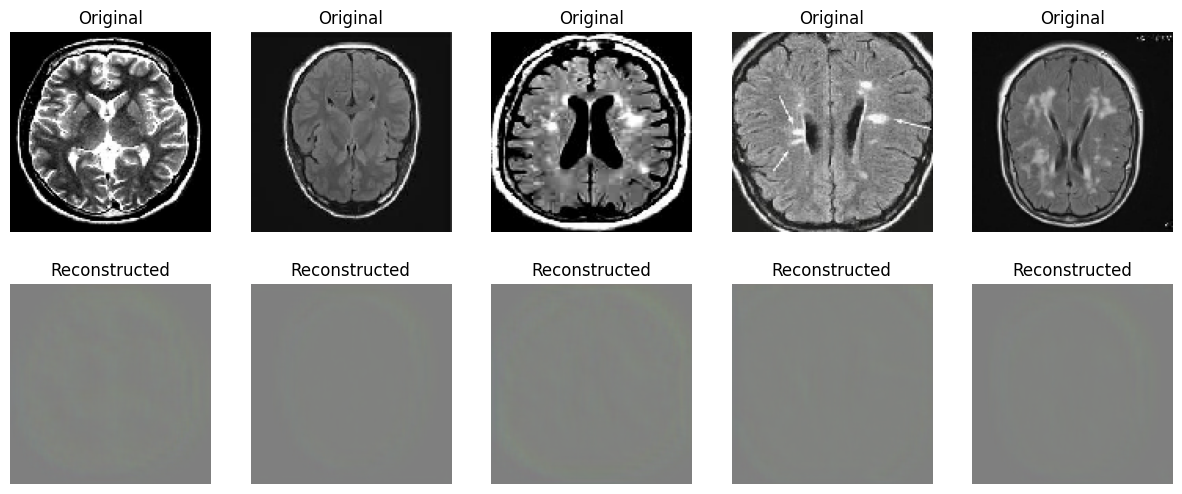

In [ ]:
sample_images, _ = next(test_generator)
predicted_images = autoencoder.predict(sample_images)

n = 5
plt.figure(figsize=(15, 6))
for i in range(n):
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(sample_images[i])
    plt.title("Original")
    plt.axis("off")

    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(predicted_images[i])
    plt.title("Reconstructed")
    plt.axis("off")
plt.show()

Anomaly Detection on test set

In [ ]:
def compute_reconstruction_error(img_array, model):
    reconstructed = model.predict(img_array)
    return np.mean(np.square(img_array - reconstructed))


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import numpy as np

def detect_anomalies_in_generator(generator, model, threshold=0.01):
    generator.reset()
    y_true_auto = []
    y_pred_auto = []
    normal_count = 0
    anomaly_count = 0

    for i in range(len(generator)):
        x_batch, _ = generator[i]
        labels = generator.classes[generator.index_array[i * generator.batch_size : (i + 1) * generator.batch_size]]

        for j, x in enumerate(x_batch):
            img = np.expand_dims(x, axis=0)
            error = compute_reconstruction_error(img, model)
            predicted_label = 1 if error > threshold else 0
            true_label = labels[j]  # 0 = notumor, 1 = tumor

            y_pred_auto.append(predicted_label)
            y_true_auto.append(true_label)

            if predicted_label == 1:
                anomaly_count += 1
            else:
                normal_count += 1

    total = normal_count + anomaly_count

    # Print detection summary
    print("\n--- Autoencoder Anomaly Detection on Test Set ---")
    print(f"Total Test Images: {total}")
    print(f"Predicted Normal (No Tumor): {normal_count} ({normal_count / total:.2%})")
    print(f"Predicted Anomaly (Tumor): {anomaly_count} ({anomaly_count / total:.2%})")

    # Metrics
    acc = accuracy_score(y_true_auto, y_pred_auto)
    prec = precision_score(y_true_auto, y_pred_auto)
    rec = recall_score(y_true_auto, y_pred_auto)
    f1 = f1_score(y_true_auto, y_pred_auto)
    cm = confusion_matrix(y_true_auto, y_pred_auto)

    print("\n--- Classification Metrics ---")
    print(f"Accuracy: {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall: {rec:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print("\nConfusion Matrix:")
    print(cm)
        # Plot confusion matrix
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Tumor', 'Tumor'], yticklabels=['No Tumor', 'Tumor'])
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix - Autoencoder Anomaly Detection')
    plt.tight_layout()
    plt.show()


    return np.array(y_true_auto), np.array(y_pred_auto)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━

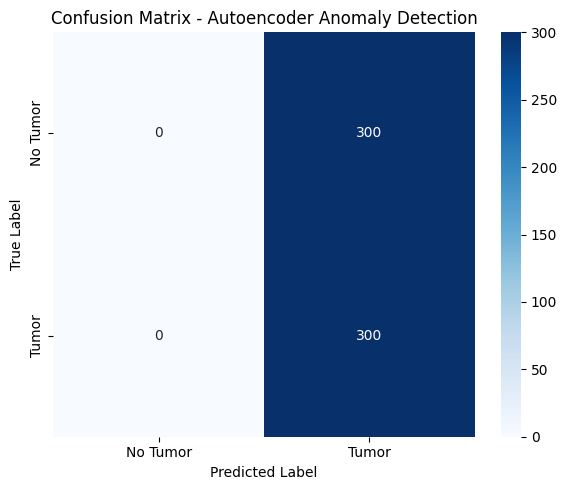

In [ ]:
y_true_auto, y_pred_auto = detect_anomalies_in_generator(test_generator, autoencoder, threshold=0.01)


In [ ]:
from sklearn.metrics import classification_report

print("\n--- Detailed Classification Report ---")
print(classification_report(y_true_auto, y_pred_auto, target_names=['Notumor', 'Tumor']))



--- Detailed Classification Report ---
              precision    recall  f1-score   support

     Notumor       0.00      0.00      0.00       300
       Tumor       0.50      1.00      0.67       300

    accuracy                           0.50       600
   macro avg       0.25      0.50      0.33       600
weighted avg       0.25      0.50      0.33       600



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### Resnet

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1./255,)

val_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary',
    shuffle=True
)

val_generator = val_datagen.flow_from_directory(
    test_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False
)


Found 2400 images belonging to 2 classes.
Found 600 images belonging to 2 classes.


In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, Input

base_model = ResNet50(weights='imagenet',
                      include_top=False,
                      input_tensor=Input(shape=(128, 128, 3)))
base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(1, activation='sigmoid')(x)

resnet_model = Model(inputs=base_model.input, outputs=output)

resnet_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
resnet_model.summary()


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 134, 134,  │          0 │ input_layer_1[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 64, 64,    │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 64, 64,    │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 64, 64,    │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 66, 66,    │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 32, 32,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 32, 32,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 32, 32,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 32, 32,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 32, 32,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 32, 32,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 32, 32,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 32, 32,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 32, 32,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 32, 32,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 32, 32,    │      1,024 │ conv2_block1_3_c

 Total params: 23,850,113 (90.98 MB)

 Trainable params: 262,401 (1.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau # Import ReduceLROnPlateau

# Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, verbose=1)

# Train top layers
history_stage1 = resnet_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=20,
    callbacks=[early_stop, reduce_lr]
)

Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_12']
Received: inputs=Tensor(shape=(None, 128, 128, 3))
  warnings.warn(msg)


75/75 ━━━━━━━━━━━━━━━━━━━━ 44s 521ms/step - accuracy: 0.5601 - loss: 0.6967 - val_accuracy: 0.6533 - val_loss: 0.6163 - learning_rate: 0.0010
Epoch 2/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 40s 531ms/step - accuracy: 0.6878 - loss: 0.5901 - val_accuracy: 0.7117 - val_loss: 0.5637 - learning_rate: 0.0010
Epoch 3/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 36s 485ms/step - accuracy: 0.7333 - loss: 0.5377 - val_accuracy: 0.7233 - val_loss: 0.5539 - learning_rate: 0.0010
Epoch 4/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 37s 490ms/step - accuracy: 0.7539 - loss: 0.5109 - val_accuracy: 0.7200 - val_loss: 0.5499 - learning_rate: 0.0010
Epoch 5/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 36s 485ms/step - accuracy: 0.7618 - loss: 0.5057 - val_accuracy: 0.7333 - val_loss: 0.5363 - learning_rate: 0.0010
Epoch 6/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 36s 481ms/step - accuracy: 0.7706 - loss: 0.5070 - val_accuracy: 0.7350 - val_loss: 0.5396 - learning_rate: 0.0010
Epoch 7/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 380ms/step - accuracy: 0.7587 - loss: 0.5141
Epoch 7

In [ ]:
# Unfreeze top 30 layers of ResNet50
for layer in base_model.layers[-30:]:
    layer.trainable = True

# Recompile with lower learning rate
resnet_model.compile(optimizer=tf.keras.optimizers.Adam(1e-5),
                     loss='binary_crossentropy',
                     metrics=['accuracy'])

# Continue training
history_stage2 = resnet_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,
    callbacks=[early_stop, reduce_lr]
)


Epoch 1/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 27s 135ms/step - accuracy: 0.6962 - loss: 6.5233 - val_accuracy: 0.7583 - val_loss: 0.7593 - learning_rate: 1.0000e-05
Epoch 2/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 5s 65ms/step - accuracy: 0.8960 - loss: 0.3460 - val_accuracy: 0.7150 - val_loss: 1.2135 - learning_rate: 1.0000e-05
Epoch 3/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.9323 - loss: 0.1977
Epoch 3: ReduceLROnPlateau reducing learning rate to 1.9999999494757505e-06.
75/75 ━━━━━━━━━━━━━━━━━━━━ 5s 64ms/step - accuracy: 0.9324 - loss: 0.1973 - val_accuracy: 0.7917 - val_loss: 0.9079 - learning_rate: 1.0000e-05
Epoch 4/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 5s 67ms/step - accuracy: 0.9665 - loss: 0.0946 - val_accuracy: 0.8833 - val_loss: 0.3934 - learning_rate: 2.0000e-06
Epoch 5/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 5s 67ms/step - accuracy: 0.9749 - loss: 0.0744 - val_accuracy: 0.9183 - val_loss: 0.2936 - learning_rate: 2.0000e-06
Epoch 6/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 5s 67ms/step - accuracy: 0.9801 - 

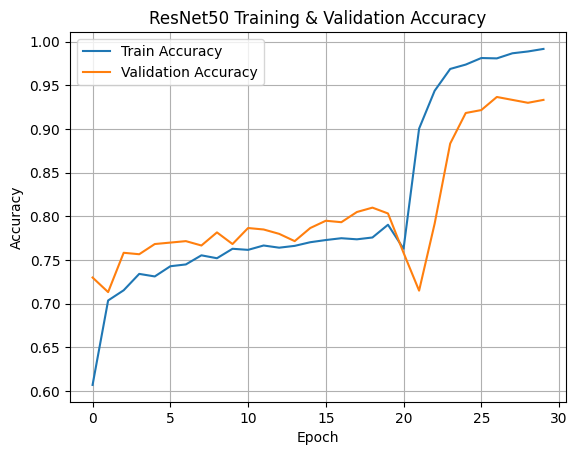

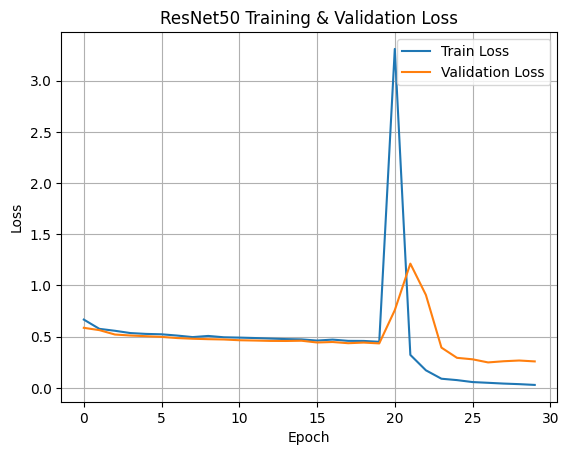

In [ ]:
# Combine metrics from both training stages
def combine_histories(h1, h2):
    history = {}
    for key in h1.history:
        history[key] = h1.history[key] + h2.history[key]
    return history

# Combine
combined_history = combine_histories(history_stage1, history_stage2)

# Plot Accuracy
plt.plot(combined_history['accuracy'], label='Train Accuracy')
plt.plot(combined_history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('ResNet50 Training & Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)
plt.show()

# Plot Loss
plt.plot(combined_history['loss'], label='Train Loss')
plt.plot(combined_history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('ResNet50 Training & Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()


In [ ]:
# Evaluate on Validation Set
test_loss, test_acc = resnet_model.evaluate(val_generator)
print(f"Validation Accuracy: {test_acc}")

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.9484 - loss: 0.2541
Validation Accuracy: 0.9366666674613953


ANOMALY DETECTION

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_12']
Received: inputs=Tensor(shape=(32, 128, 128, 3))
  warnings.warn(msg)


19/19 ━━━━━━━━━━━━━━━━━━━━ 7s 215ms/step
Classification Report on Test Set:
              precision    recall  f1-score   support

    No Tumor       0.92      0.96      0.94       300
       Tumor       0.96      0.92      0.94       300

    accuracy                           0.94       600
   macro avg       0.94      0.94      0.94       600
weighted avg       0.94      0.94      0.94       600



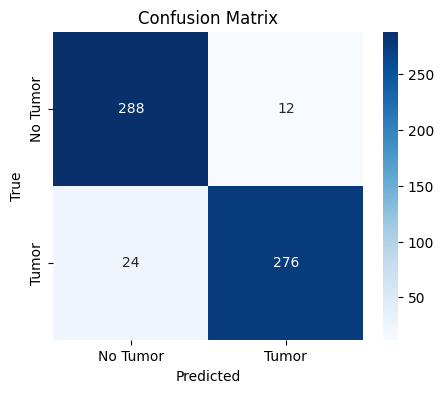


Total Test Samples: 600
Predicted Normal (No Tumor): 312 (52.00%)
Predicted Anomalous (Tumor): 288 (48.00%)


In [ ]:
# Predict
test_generator.reset()
test_probs = resnet_model.predict(test_generator)
threshold = 0.6  # Same as used for individual/folder prediction
y_pred_rest = (test_probs > threshold).astype(int).ravel()
y_true_rest = test_generator.classes

# Evaluation Metrics
print("Classification Report on Test Set:")
print(classification_report(y_true_rest, y_pred_rest, target_names=["No Tumor", "Tumor"]))

# Confusion Matrix
conf_mat = confusion_matrix(y_true_rest, y_pred_rest)
plt.figure(figsize=(5, 4))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues',
            xticklabels=["No Tumor", "Tumor"],
            yticklabels=["No Tumor", "Tumor"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# Count Prediction Summary
total_test = len(y_pred_rest)
normal_test = (y_pred_rest == 0).sum()
anomaly_test = (y_pred_rest == 1).sum()

print(f"\nTotal Test Samples: {total_test}")
print(f"Predicted Normal (No Tumor): {normal_test} ({normal_test / total_test:.2%})")
print(f"Predicted Anomalous (Tumor): {anomaly_test} ({anomaly_test / total_test:.2%})")

In [ ]:
# Predict for a single image
def predict_anomaly(image_path, model, threshold=0.6):
    img = load_img(image_path, target_size=(128, 128))
    img_array = img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    pred_prob = model.predict(img_array)[0][0]
    is_anomalous = int(pred_prob > threshold)
    label = 'Anomalous (Tumor)' if is_anomalous else 'Normal (No Tumor)'

    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Prediction: {label} ({pred_prob:.2f})")
    plt.show()

    return label, pred_prob



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


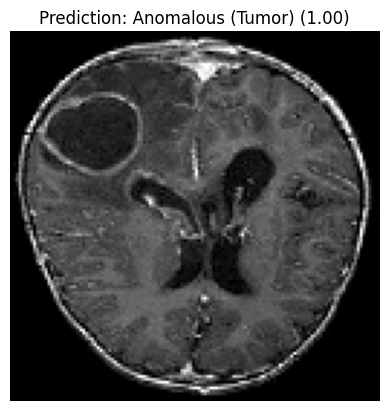

Status: Anomalous (Tumor)


In [ ]:
# Single image prediction
img_path = "/content/brain_tumor/Brain_Tumor_Detection/yes/y1023.jpg"
status, confidence = predict_anomaly(img_path, resnet_model)
print(f"Status: {status}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


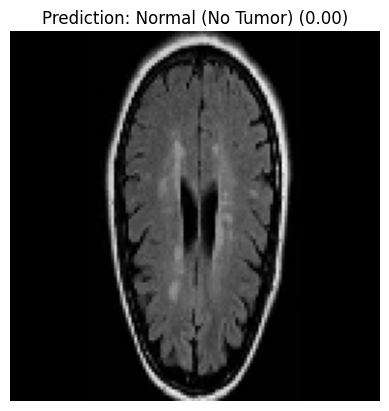

Status: Normal (No Tumor)


In [ ]:
img_path = "/content/brain_tumor/Brain_Tumor_Detection/no/No13.jpg"
status, confidence = predict_anomaly(img_path, resnet_model)
print(f"Status: {status}")


In [ ]:
# Predict all images in a folder
def predict_folder_anomalies(folder_path, model, threshold=0.6):
    normal_count = 0
    anomaly_count = 0
    image_files = [f for f in os.listdir(folder_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

    for img_name in image_files:
        img_path = os.path.join(folder_path, img_name)
        img = load_img(img_path, target_size=(128, 128))
        img_array = img_to_array(img) / 255.0
        img_array = np.expand_dims(img_array, axis=0)

        pred_prob = model.predict(img_array)[0][0]
        pred_class = int(pred_prob > threshold)

        if pred_class == 1:
            anomaly_count += 1
        else:
            normal_count += 1

    total = normal_count + anomaly_count
    print(f"\nScanned Folder: {folder_path}")
    print(f"Total Images: {total}")
    print(f"Predicted Normal: {normal_count} ({normal_count / total:.2%})")
    print(f"Predicted Anomaly: {anomaly_count} ({anomaly_count / total:.2%})")

    return normal_count, anomaly_count

In [ ]:
# Folder prediction
predict_folder_anomalies("/content/brain_tumor/Brain_Tumor_Detection/pred", resnet_model, threshold=0.6)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━

(34, 26)

#Comparison

In [ ]:
import pandas as pd

# === Metrics already calculated ===
# Autoencoder
auto_metrics = {
    "Model": "Autoencoder",
    "Accuracy": accuracy_score(y_true_auto, y_pred_auto),
    "Precision": precision_score(y_true_auto, y_pred_auto),
    "Recall": recall_score(y_true_auto, y_pred_auto),
    "F1 Score": f1_score(y_true_auto, y_pred_auto)
}

# ResNet
resnet_metrics = {
    "Model": "ResNet",
    "Accuracy": accuracy_score(y_true_rest, y_pred_rest),
    "Precision": precision_score(y_true_rest, y_pred_rest),
    "Recall": recall_score(y_true_rest, y_pred_rest),
    "F1 Score": f1_score(y_true_rest, y_pred_rest)
}

# === Create DataFrame for Comparison ===
metrics_df = pd.DataFrame([auto_metrics, resnet_metrics])
print("Performance Comparison Table:")
display(metrics_df)


Performance Comparison Table:


,Model,Accuracy,Precision,Recall,F1 Score
0,Autoencoder,0.571667,0.672000,0.28,0.395294
1,ResNet,0.940000,0.958333,0.92,0.938776


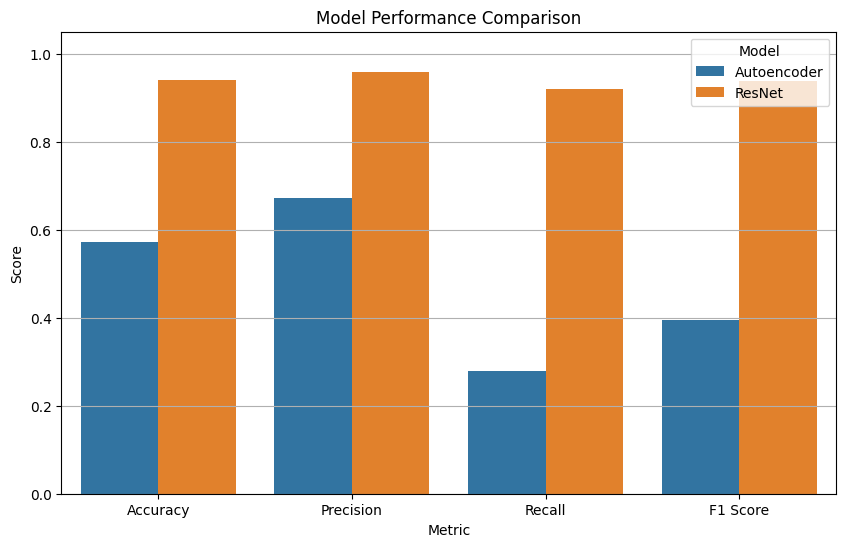

In [ ]:
# === Bar Plot of Metrics ===
metrics_melted = metrics_df.melt(id_vars="Model", var_name="Metric", value_name="Score")
plt.figure(figsize=(10, 6))
sns.barplot(data=metrics_melted, x="Metric", y="Score", hue="Model")
plt.title("Model Performance Comparison")
plt.ylim(0, 1.05)
plt.ylabel("Score")
plt.grid(True, axis='y')
plt.show()


In [ ]:
y_true = test_generator.classes


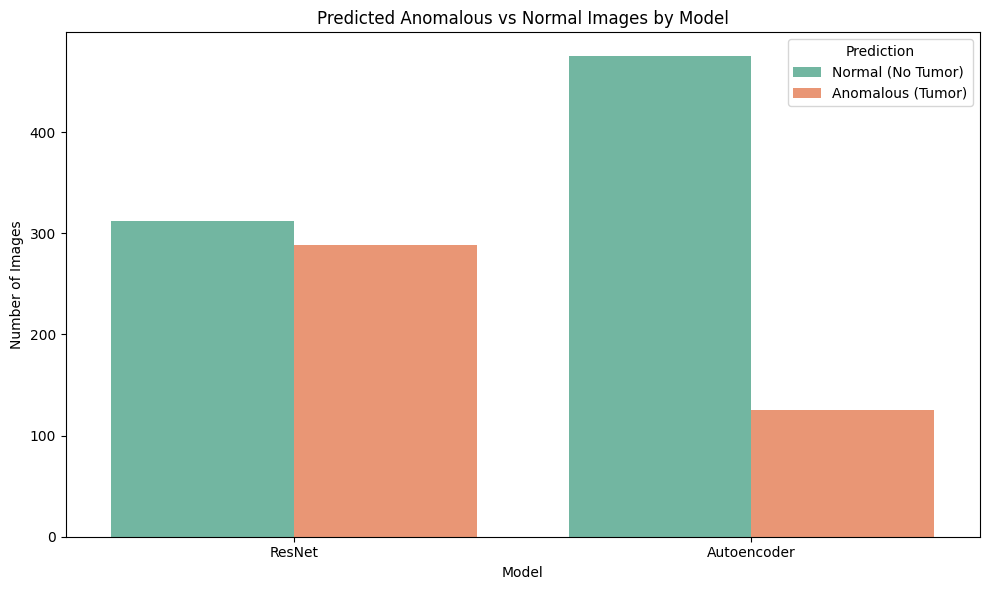

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Create DataFrames
df_resnet = pd.DataFrame({
    'Model': ['ResNet'] * len(y_pred_rest),
    'True Label': y_true_rest,
    'Predicted Label': y_pred_rest
})

df_autoencoder = pd.DataFrame({
    'Model': ['Autoencoder'] * len(y_pred_auto),
    'True Label': y_true_auto,
    'Predicted Label': y_pred_auto
})

# Combine both
df_all = pd.concat([df_resnet, df_autoencoder])

# Map 0/1 to labels
label_map = {0: 'Normal (No Tumor)', 1: 'Anomalous (Tumor)'}
df_all['Predicted Class'] = df_all['Predicted Label'].map(label_map)

# Plotting
plt.figure(figsize=(10, 6))
sns.countplot(data=df_all, x='Model', hue='Predicted Class', palette='Set2')
plt.title('Predicted Anomalous vs Normal Images by Model')
plt.ylabel('Number of Images')
plt.xlabel('Model')
plt.legend(title='Prediction')
plt.tight_layout()
plt.show()
